In [216]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter

# Setting agar hasil acak tetap sama
np.random.seed(42)

# 1. BUAT DATA DUMMY (1000 Karyawan)
n_samples = 1000

data = {
    'ID_Karyawan': range(1, n_samples + 1),
    'Umur': np.random.randint(22, 55, n_samples),
    'Divisi': np.random.choice(['IT', 'HR', 'Sales', 'Finance'], n_samples),
    'Jarak_Rumah_km': np.random.exponential(scale=10, size=n_samples).astype(int), # Jarak normal
    'Nilai_Kinerja': np.random.choice([1, 2, 3, 4, 5], n_samples),
}

df = pd.DataFrame(data)

# 2. BIKIN KOTOR: Masalah Format Gaji (Jadi Teks "Rp ...")
gaji_murni = np.random.randint(5, 25, n_samples) * 1000000 # 5jt - 25jt
df['Gaji'] = [f"Rp {x:,.0f}".replace(",", ".") for x in gaji_murni]

# 3. BIKIN KOTOR: Masalah Missing Values (Data Bolong)
# Kita hapus acak 20 data Nilai Kinerja
idx_bolong = np.random.choice(df.index, 20, replace=False)
df.loc[idx_bolong, 'Nilai_Kinerja'] = np.nan

# 4. BIKIN KOTOR: Masalah Outlier (Jarak Rumah Ekstrem)
# Ada 5 orang yang jarak rumahnya 500 km (Mustahil ngantor tiap hari)
df.loc[0:5, 'Jarak_Rumah_km'] = 500

# 5. BIKIN TARGET (Resign) - Imbalance
# Logika: Gaji kecil & Jarak jauh -> Cenderung Resign
# Kita buat manual targetnya biar ada pola
resign_prob = (gaji_murni < 8000000).astype(int) * 0.4 + (df['Jarak_Rumah_km'] > 30).astype(int) * 0.4
target = (np.random.rand(n_samples) < resign_prob).astype(int)
df['Resign'] = target

print("✅ Data Kotor Siap! Coba lihat 5 baris pertama:")
display(df.head())
print("\nInfo Tipe Data (Perhatikan Gaji jadi Object/Teks):")
print(df.info())

✅ Data Kotor Siap! Coba lihat 5 baris pertama:


,ID_Karyawan,Umur,Divisi,Jarak_Rumah_km,Nilai_Kinerja,Gaji,Resign
0,1,50,IT,500,1.0,Rp 16.000.000,0
1,2,36,Finance,500,3.0,Rp 23.000.000,0
2,3,29,Sales,500,2.0,Rp 13.000.000,0
3,4,42,Sales,500,1.0,Rp 11.000.000,1
4,5,40,IT,500,NaN,Rp 18.000.000,0



Info Tipe Data (Perhatikan Gaji jadi Object/Teks):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID_Karyawan     1000 non-null   int64  
 1   Umur            1000 non-null   int64  
 2   Divisi          1000 non-null   object 
 3   Jarak_Rumah_km  1000 non-null   int64  
 4   Nilai_Kinerja   980 non-null    float64
 5   Gaji            1000 non-null   object 
 6   Resign          1000 non-null   int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 54.8+ KB
None


In [217]:
df

,ID_Karyawan,Umur,Divisi,Jarak_Rumah_km,Nilai_Kinerja,Gaji,Resign
0,1,50,IT,500,1.0,Rp 16.000.000,0
1,2,36,Finance,500,3.0,Rp 23.000.000,0
2,3,29,Sales,500,2.0,Rp 13.000.000,0
3,4,42,Sales,500,1.0,Rp 11.000.000,1
4,5,40,IT,500,NaN,Rp 18.000.000,0
...,...,...,...,...,...,...,...
995,996,46,Finance,6,1.0,Rp 18.000.000,0
996,997,24,HR,7,5.0,Rp 6.000.000,0
997,998,51,HR,8,1.0,Rp 19.000.000,0
998,999,33,Sales,5,1.0,Rp 16.000.000,0


In [218]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID_Karyawan     1000 non-null   int64  
 1   Umur            1000 non-null   int64  
 2   Divisi          1000 non-null   object 
 3   Jarak_Rumah_km  1000 non-null   int64  
 4   Nilai_Kinerja   980 non-null    float64
 5   Gaji            1000 non-null   object 
 6   Resign          1000 non-null   int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 54.8+ KB


In [219]:
df['Gaji'] = df['Gaji'].str.replace('Rp', '')
df['Gaji'] = df['Gaji'].str.replace('.', '')



In [220]:
df['Gaji'] = pd.to_numeric(df['Gaji'])

In [221]:
df

,ID_Karyawan,Umur,Divisi,Jarak_Rumah_km,Nilai_Kinerja,Gaji,Resign
0,1,50,IT,500,1.0,16000000,0
1,2,36,Finance,500,3.0,23000000,0
2,3,29,Sales,500,2.0,13000000,0
3,4,42,Sales,500,1.0,11000000,1
4,5,40,IT,500,NaN,18000000,0
...,...,...,...,...,...,...,...
995,996,46,Finance,6,1.0,18000000,0
996,997,24,HR,7,5.0,6000000,0
997,998,51,HR,8,1.0,19000000,0
998,999,33,Sales,5,1.0,16000000,0


In [222]:
df.isnull().sum()

ID_Karyawan        0
Umur               0
Divisi             0
Jarak_Rumah_km     0
Nilai_Kinerja     20
Gaji               0
Resign             0
dtype: int64

In [223]:
df['Nilai_Kinerja'] = df['Nilai_Kinerja'].fillna(df['Nilai_Kinerja'].mean())

In [224]:
print('Persebaran kelas sebelum SMOTE :', Counter(df['Resign']))

Persebaran kelas sebelum SMOTE : Counter({0: 934, 1: 66})


In [225]:
df.select_dtypes('number')

,ID_Karyawan,Umur,Jarak_Rumah_km,Nilai_Kinerja,Gaji,Resign
0,1,50,500,1.000000,16000000,0
1,2,36,500,3.000000,23000000,0
2,3,29,500,2.000000,13000000,0
3,4,42,500,1.000000,11000000,1
4,5,40,500,2.939796,18000000,0
...,...,...,...,...,...,...
995,996,46,6,1.000000,18000000,0
996,997,24,7,5.000000,6000000,0
997,998,51,8,1.000000,19000000,0
998,999,33,5,1.000000,16000000,0


In [226]:
df.describe()

,ID_Karyawan,Umur,Jarak_Rumah_km,Nilai_Kinerja,Gaji,Resign
count,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000
mean,500.500000,38.370000,12.137000,2.939796,1.491100e+07,0.066000
std,288.819436,9.820873,39.148216,1.421080,5.631767e+06,0.248406
min,1.000000,22.000000,0.000000,1.000000,5.000000e+06,0.000000
25%,250.750000,30.000000,2.000000,2.000000,1.000000e+07,0.000000
50%,500.500000,39.000000,6.000000,3.000000,1.500000e+07,0.000000
75%,750.250000,47.000000,13.000000,4.000000,2.000000e+07,0.000000
max,1000.000000,54.000000,500.000000,5.000000,2.400000e+07,1.000000


/tmp/ipykernel_19256/2858679198.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df[column], palette='viridis')
/tmp/ipykernel_19256/2858679198.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df[column], palette='viridis')
/tmp/ipykernel_19256/2858679198.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df[column], palette='viridis')
/tmp/ipykernel_19256/2858679198.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for

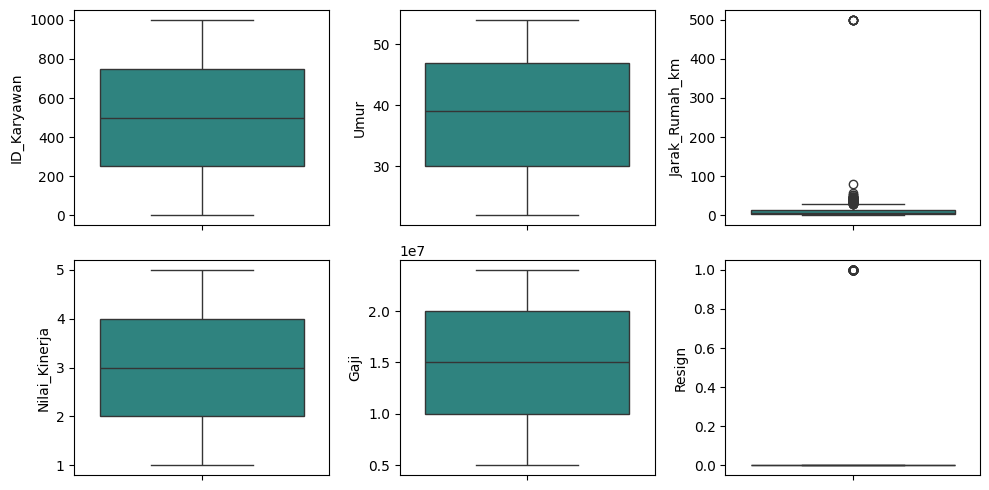

In [230]:
import matplotlib.pyplot as sns
import seaborn as sns

plt.figure(figsize=(10, 5))
for i, column in enumerate(df.select_dtypes('number').columns):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(df[column], palette='viridis')
plt.tight_layout()
plt.show()

In [228]:
numerical = df.select_dtypes('number').columns

In [214]:
# q1 = df[numerical].quantile(0.25)
# q3 = df[numerical].quantile(0.75)

# iqr = q3 - q1 
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# outlier = ~((df[numerical] < lower) | (df[numerical] > upper)).any(axis=1)
# numerical_features = df.loc[outlier, numerical]
# numerical_features

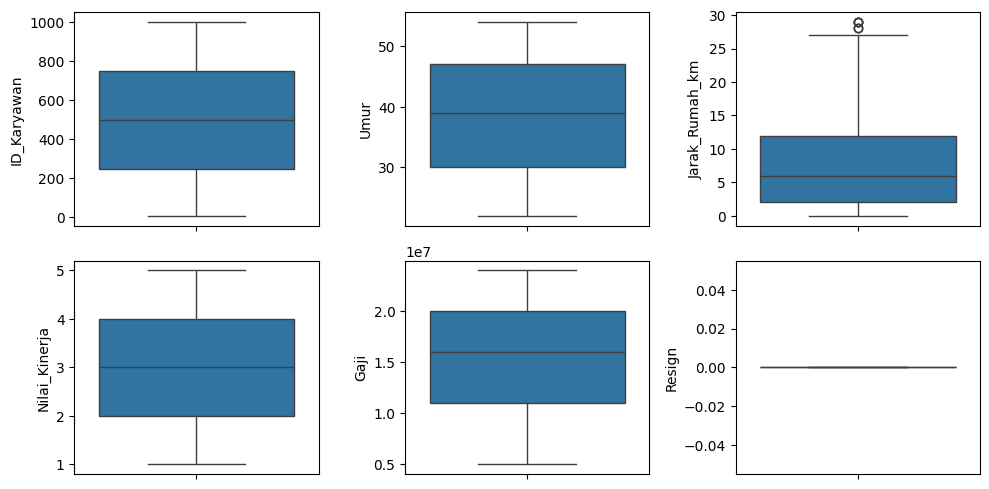

In [229]:
plt.figure(figsize=(10,5))
for i, column in enumerate(numerical_features):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(numerical_features[column])
plt.tight_layout()
plt.show()

In [ ]:
numerical_features.isnull().sum()

ID_Karyawan       0
Umur              0
Jarak_Rumah_km    0
Nilai_Kinerja     0
Gaji              0
Resign            0
dtype: int64

In [ ]:
numerical_features.duplicated().sum()

np.int64(0)

In [ ]:
categorical = df.select_dtypes('object')
categorical

,Divisi
0,IT
1,Finance
2,Sales
3,Sales
4,IT
...,...
995,Finance
996,HR
997,HR
998,Sales


900

In [232]:
# numerical_features['Divisi'] = df['Divisi']
# df = numerical_features

df = pd.get_dummies(df, columns=['Divisi'], dtype=int)


In [233]:
df

,ID_Karyawan,Umur,Jarak_Rumah_km,Nilai_Kinerja,Gaji,Resign,Divisi_Finance,Divisi_HR,Divisi_IT,Divisi_Sales
0,1,50,500,1.000000,16000000,0,0,0,1,0
1,2,36,500,3.000000,23000000,0,1,0,0,0
2,3,29,500,2.000000,13000000,0,0,0,0,1
3,4,42,500,1.000000,11000000,1,0,0,0,1
4,5,40,500,2.939796,18000000,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
995,996,46,6,1.000000,18000000,0,1,0,0,0
996,997,24,7,5.000000,6000000,0,0,1,0,0
997,998,51,8,1.000000,19000000,0,0,1,0,0
998,999,33,5,1.000000,16000000,0,0,0,0,1


In [234]:
df['Resign'].value_counts()

Resign
0    934
1     66
Name: count, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

x = df.drop('Resign', axis=1)
y = df['Resign']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
len(x_train), len(x_test)

smote = SMOTE(random_state=42)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

print(f'Distribusi data setelah SMOTE : {Counter(y_train_smote)}')

#mengubah data menjadi dataframe untuk keperluan visualisasi dan lain-lain
x_resampled = pd.DataFrame(x_train_smote)
y_resampled = pd.Series(y_train_smote, name='Target')

Distribusi data setelah SMOTE : Counter({0: 744, 1: 744})


0       0
1       0
2       0
3       0
4       0
       ..
1483    1
1484    1
1485    1
1486    1
1487    1
Name: Target, Length: 1488, dtype: int64

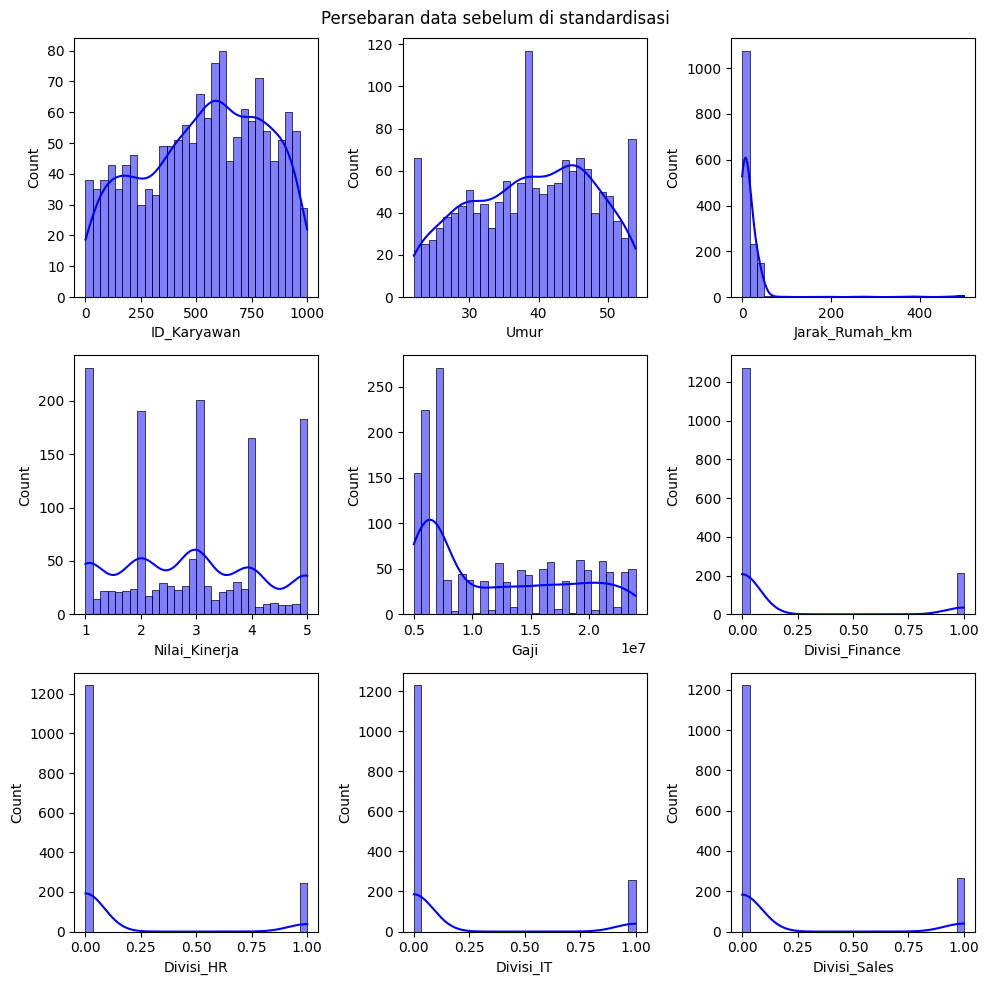

In [266]:
plt.figure(figsize=(10, 10))
for i, column in enumerate(x_resampled):
   plt.suptitle('Persebaran data sebelum di standardisasi')
   plt.subplot(3, 3, i + 1)
   sns.histplot(x_resampled[column], kde=True, color='blue', bins=30)
plt.tight_layout()

plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

scaler = StandardScaler()
df_scaler = scaler.fi

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
numerical = df.select_

AttributeError: 'DataFrame' object has no attribute 'select_'